In [1]:
import sys
import os

sys.path.append("../")
os.chdir("../")

In [2]:
import yaml
import json
from tqdm import tqdm
from mirrorbench.io.paths import Paths
from mirrorbench.core.run_db.sqlite import SQLiteRunDatabase
from mirrorbench.metrics.judge.prompts import format_few_shot_examples, PAIRWISE_PROMPT_SYSTEM, PAIRWISE_PROMPT_USER
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from cached_scripts import ChatOpenAI, ChatBedrockConverse, ChatVertexAI

/mnt/shared-fs-1/ashutosh/mirrorbench/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Model: sonar-pro, Config Name: sonar-pro-config
Model: sonar, Config Name: sonar-config
Model: cohere--command-a-reasoning, Config Name: cohere--command-a-reasoning-config
Model: mistralai--mistral-medium-instruct, Config Name: mistralai--mistral-medium-instruct-config
Model: gemini-2.0-flash-lite, Config Name: gemini-2.0-flash-lite-default
Model: gemini-2.0-flash, Config Name: gemini-2.0-flash-default
Model: gemini-1.5-pro, Config Name: gemini-1.5-pro-default
Model: meta--llama3.1-70b-instruct, Config Name: meta--llama3.1-70b-instruct-default
Model: mistralai--mistral-small-instruct, Config Name: mistralai--mistral-small-instruct-default
Model: anthropic--claude-3.7-sonnet, Config Name: anthropic--claude-3.7-sonnet-default
Model: anthropic--claude-3-opus, Config Name: anthropic--claude-3-opus-default
Model: anthropic--claude-3-sonnet, Config Name: anthropic--claude-3-sonnet-default
Model: anthropic--claude-3-haiku, Config Name: anthropic--claude-3-haiku-default
Model: text-embedding-3

In [3]:
# messages = [
#     SystemMessage(content="You are a helpful assistant."),
#     HumanMessage(content="Hello, how are you?"),
# ]
# output = "I am doing well, thank you!"

# # llm = ChatOpenAI(model="gpt-4o", config_name="gpt-4o-default")
# llm = ChatBedrockConverse(model="anthropic--claude-4-sonnet")
# # llm = ChatVertexAI(model="gemini-2.5-pro")
# tokens = llm.get_num_tokens_from_messages(messages=messages)
# gen_tokens = llm.get_num_tokens(output)
# print(f"Number of tokens from messages: {tokens}")
# print(f"Number of tokens from output: {gen_tokens}")

In [4]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [5]:
CONFIG_DIRPATH = 'configs'
UNIVERSAL_JUDGE_SUBSTR = 'claude-4-sonnet-judge'  # 'claude-4-sonnet-judge'
DATASETS = [
    'chatbot_arena_mirror',
    'clariq_mirror',
    'oasst1_mirror',
    'qulac_mirror'
]

paths = Paths.default()

In [6]:
run_names = []
dataset_to_run_names = {dataset: [] for dataset in DATASETS}

for dirpath, _, filenames in os.walk(CONFIG_DIRPATH):
    for filename in filenames:
        if not filename.endswith('.yaml'):
            continue
        with open(os.path.join(dirpath, filename), 'r') as f:
            run_config = yaml.safe_load(f)
        name = run_config['run']['name']
        if UNIVERSAL_JUDGE_SUBSTR in name:
            run_names.append(name)

print(f"Found {len(run_names)} runs with universal judge:")

for dataset in DATASETS:
    for run_name in run_names:
        if "gpt-oss-120b-user" in run_name:
            continue
        if dataset in run_name:
            dataset_to_run_names[dataset].append(run_name)

for dataset, names in dataset_to_run_names.items():
    print(f"{dataset}: {len(names)} runs")
    for name in names:
        print(f"  - {name}")

Found 20 runs with universal judge:
chatbot_arena_mirror: 4 runs
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
clariq_mirror: 4 runs
  - clariq_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge
oasst1_mirror: 4 runs
  - oasst1_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - oasst1_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge
  - oasst1_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
  - oasst1_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-

In [7]:
def get_dataset_from_episode(episode):
    for dataset in DATASETS:
        if dataset in episode["unit_id"]:
            return dataset
    raise ValueError(f"Unknown dataset in episode {episode['unit_id']}")


def read_episode_artifact(episode, paths: Paths):
    artifact_path = episode["artifact_path"]
    if artifact_path is None:
        return None
    with open(os.path.join(str(paths.run_dir(run_name)), artifact_path), "r") as f:
        data = json.loads(f.read())
    return data


def get_user_assistant_tokens(artifact):
    try:
        user_usage = {
            "tokens_input": 0,
            "tokens_output": 0,
        }
        assistant_usage = {
            "tokens_input": 0,
            "tokens_output": 0,
        }
        artifact_turns = artifact["turns"]
        if 'qulac' in artifact['spec']['episode_id']:
            # QuLAC has an extra initial assistant message that is not counted in telemetry
            artifact_turns = artifact_turns[1:]
        turn_length = len(artifact_turns)
        telemetry_length = len(artifact['telemetry'])
        assert turn_length == telemetry_length, f"Turn length {turn_length} != telemetry length {telemetry_length}"
        for idx, tel in enumerate(artifact["telemetry"]):
            turn = artifact_turns[idx]
            if idx % 2 == 0:
                assert turn["role"] == "user", f"Expected user role at even index {idx}, got {turn['role']}"
                for k in user_usage.keys():
                    user_usage[k] += tel[k]
            else:
                assert turn["role"] == "assistant", f"Expected assistant role at odd index {idx}, got {turn['role']}"
                for k in assistant_usage.keys():
                    assistant_usage[k] += tel[k]
        return user_usage, assistant_usage
    except Exception as e:
        return None, None


def _format_conversation(messages) -> str:
    """Render a sequence of messages into a deterministic transcript."""

    lines: list[str] = []
    for message in messages:
        lines.append(f"{message['role'].upper()}: {message['content']}")
    return "\n".join(lines)


def get_single_judgement_tokens(llm, conv_a, conv_b, few_shot, output):
    messages = [
        SystemMessage(
            content=PAIRWISE_PROMPT_SYSTEM
        ),
        HumanMessage(
            content=PAIRWISE_PROMPT_USER.format(
                few_shot_examples=few_shot,
                conversation_a=conv_a,
                conversation_b=conv_b,
            )
        )
    ]
    input_tokens = llm.get_num_tokens_from_messages(messages=messages)
    output_tokens = llm.get_num_tokens(output)
    return input_tokens, output_tokens


def get_paired_judgement_tokens(llm, conv_a, conv_b, few_shot, verdicts, reasoning):
    assert len(verdicts) == len(reasoning), "Verdicts and reasoning length mismatch"
    judge_usage = {
        "tokens_input": 0,
        "tokens_output": 0,
    }
    for ver, reas in zip(verdicts, reasoning):
        output = json.dumps({
            "verdict": ver,
            "reasoning": reas
        })
        input_tokens, output_tokens = get_single_judgement_tokens(
            llm, conv_a, conv_b, few_shot, output
        )
        judge_usage["tokens_input"] += input_tokens
        judge_usage["tokens_output"] += output_tokens
    return judge_usage


def get_all_judgement_tokens(llm, artifact):
    try:
        judge_usage = {
            "tokens_input": 0,
            "tokens_output": 0,
        }
        real_conv = _format_conversation(artifact['spec']["chat_history"])
        proxy_conv = _format_conversation(artifact["turns"])
        few_shot = format_few_shot_examples(artifact['spec']['metadata'].get("few_shot_user_examples", None))
        metadata = artifact['metric_values']['metric:judge/pi_pairwise']['metadata']
        main_usage = get_paired_judgement_tokens(
            llm,
            real_conv,
            proxy_conv,
            few_shot,
            metadata['verdicts'],
            metadata['reasonings']
        )
        hh_usage = get_paired_judgement_tokens(
            llm,
            real_conv,
            real_conv,
            few_shot,
            metadata['controls']['hh']['verdicts'],
            metadata['controls']['hh']['reasonings']
        )
        pp_usage = get_paired_judgement_tokens(
            llm,
            proxy_conv,
            proxy_conv,
            few_shot,
            metadata['controls']['pp']['verdicts'],
            metadata['controls']['pp']['reasonings']
        )
        for k in judge_usage.keys():
            judge_usage[k] = main_usage[k] + hh_usage[k] + pp_usage[k]
        return judge_usage
    except Exception as e:
        return None


def get_run_token_usage(run_id):
    llm = ChatBedrockConverse(model="anthropic--claude-4-sonnet")
    run_db = SQLiteRunDatabase(
        paths.run_db_path(run_id), run_name
    )
    run_db.initialize()
    episode_rows = run_db._connection().execute(
        "SELECT * FROM episodes WHERE run_id = ?",
        (run_db.run_id,),
    ).fetchall()
    episodes = [dict(row) for row in episode_rows]
    usage = {
        "user": {
            "tokens_input": 0,
            "tokens_output": 0,
        },
        "assistant": {
            "tokens_input": 0,
            "tokens_output": 0,
        },
        "judge": {
            "tokens_input": 0,
            "tokens_output": 0,
        }
    }
    valid_cases = 0
    good_cases = 0
    for ep in tqdm(episodes):
        if 'metric:judge/pi_pairwise' in ep['unit_id']:
            valid_cases += 1
            artifact = read_episode_artifact(ep, paths)
            user_usage, assistant_usage = get_user_assistant_tokens(artifact)
            judge_usage = get_all_judgement_tokens(llm, artifact)
            if not user_usage or not assistant_usage or not judge_usage:
                continue
            good_cases += 1
            for k in usage['user'].keys():
                usage['user'][k] += user_usage[k]
                usage['assistant'][k] += assistant_usage[k]
                usage['judge'][k] += judge_usage[k]
    print(f"Valid cases: {valid_cases}, Good cases: {good_cases}")
    return usage, good_cases

In [8]:
dataset_to_run_token_usage = {}
run_to_episode_counts = {}
for dataset, run_names in dataset_to_run_names.items():
    dataset_to_run_token_usage[dataset] = {}
    for run_name in run_names:
        print(f"Processing run: {run_name}")
        usage, ep_count = get_run_token_usage(run_name)
        run_to_episode_counts[run_name] = ep_count
        dataset_to_run_token_usage[dataset][run_name] = usage

Processing run: chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 383.50it/s]


Valid cases: 200, Good cases: 200
Processing run: chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:05<00:00, 227.46it/s]


Valid cases: 200, Good cases: 199
Processing run: chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:02<00:00, 438.02it/s]


Valid cases: 200, Good cases: 200
Processing run: chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:02<00:00, 428.44it/s]


Valid cases: 200, Good cases: 199
Processing run: clariq_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 388.00it/s]


Valid cases: 200, Good cases: 200
Processing run: clariq_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:10<00:00, 109.87it/s]


Valid cases: 200, Good cases: 143
Processing run: clariq_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 325.69it/s]


Valid cases: 200, Good cases: 199
Processing run: clariq_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 394.68it/s]


Valid cases: 200, Good cases: 199
Processing run: oasst1_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 337.89it/s]


Valid cases: 200, Good cases: 200
Processing run: oasst1_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:07<00:00, 169.59it/s]


Valid cases: 200, Good cases: 178
Processing run: oasst1_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:04<00:00, 293.87it/s]


Valid cases: 200, Good cases: 199
Processing run: oasst1_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:03<00:00, 323.35it/s]


Valid cases: 200, Good cases: 199
Processing run: qulac_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:01<00:00, 854.29it/s]


Valid cases: 200, Good cases: 200
Processing run: qulac_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:01<00:00, 657.41it/s]


Valid cases: 200, Good cases: 199
Processing run: qulac_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:01<00:00, 844.83it/s]


Valid cases: 200, Good cases: 200
Processing run: qulac_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge


100%|██████████| 1200/1200 [00:01<00:00, 879.97it/s]

Valid cases: 200, Good cases: 200


In [9]:
# run_name = "qulac_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge"
# run_db = SQLiteRunDatabase(
#     paths.run_db_path(run_name), run_name
# )
# run_db.initialize()

In [10]:
# episode_rows = run_db._connection().execute(
#     "SELECT * FROM episodes WHERE run_id = ?",
#     (run_db.run_id,),
# ).fetchall()
# episodes = [dict(row) for row in episode_rows]

In [11]:
# episodes[201]

In [12]:
# with open(os.path.join(paths.run_dir(run_name), episodes[202]['artifact_path']), 'r') as f:
#     data = json.loads(f.read())

# print(json.dumps(data, indent=4))

In [13]:
run_to_episode_counts

{'chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge': 200,
 'chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge': 200,
 'chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'clariq_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge': 200,
 'clariq_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge': 143,
 'clariq_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'clariq_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'oasst1_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge': 200,
 'oasst1_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge': 178,
 'oasst1_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'oasst1_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge': 199,
 'qulac_mirror-gpt-4o-user-gpt-4o-as

In [14]:
dataset_to_run_token_usage

{'chatbot_arena_mirror': {'chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge': {'user': {'tokens_input': 85878,
    'tokens_output': 7510},
   'assistant': {'tokens_input': 201853, 'tokens_output': 39602},
   'judge': {'tokens_input': 1707471, 'tokens_output': 164820}},
  'chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge': {'user': {'tokens_input': 316299,
    'tokens_output': 254262},
   'assistant': {'tokens_input': 497217, 'tokens_output': 138629},
   'judge': {'tokens_input': 3608406, 'tokens_output': 176823}},
  'chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge': {'user': {'tokens_input': 114102,
    'tokens_output': 12129},
   'assistant': {'tokens_input': 226944, 'tokens_output': 45677},
   'judge': {'tokens_input': 1826415, 'tokens_output': 168428}},
  'chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge': {'user': {'tokens_input': 85682,
    'tokens_output': 15608},
   'assi

In [15]:
# Extract user model from run name
def extract_user_model(run_name):
    """Extract user model from run name like 'dataset-gpt-4o-user-...'"""
    parts = run_name.split('-')
    for i, part in enumerate(parts):
        if part == 'user' and i > 0:
            # Handle multi-part model names like gpt-oss-120b
            model_parts = []
            j = i - 1
            while j >= 0 and parts[j] not in DATASETS:
                model_parts.insert(0, parts[j])
                j -= 1
            return '-'.join(model_parts)
    raise ValueError(f"Could not extract user model from {run_name}")

def extract_assistant_model(run_name):
    """Extract assistant model from run name like 'dataset-...-assistant-...'"""
    parts = run_name.split('-')
    for i, part in enumerate(parts):
        if part == 'assistant' and i > 0:
            # Handle multi-part model names like gpt-oss-120b
            model_parts = []
            j = i - 1
            while j >= 0 and parts[j] != "user":
                model_parts.insert(0, parts[j])
                j -= 1
            return '-'.join(model_parts)
    raise ValueError(f"Could not extract assistant model from {run_name}")

def extract_judge_model(run_name):
    """Extract judge model from run name like 'dataset-...-judge'"""
    parts = run_name.split('-')
    for i, part in enumerate(parts):
        if part == 'judge' and i > 0:
            # Handle multi-part model names like claude-4-sonnet
            model_parts = []
            j = i - 1
            while j >= 0 and parts[j] != "assistant":
                model_parts.insert(0, parts[j])
                j -= 1
            return '-'.join(model_parts)
    raise ValueError(f"Could not extract judge model from {run_name}")

# Test extraction
for dataset in DATASETS:
    if dataset_to_run_names[dataset]:
        run_name = dataset_to_run_names[dataset][0]
        print(f"{dataset}: User->{extract_user_model(run_name)} Assistant->{extract_assistant_model(run_name)} Judge->{extract_judge_model(run_name)}")

chatbot_arena_mirror: User->gpt-4o Assistant->gpt-4o Judge->claude-4-sonnet
clariq_mirror: User->gpt-4o Assistant->gpt-4o Judge->claude-4-sonnet
oasst1_mirror: User->gpt-4o Assistant->gpt-4o Judge->claude-4-sonnet
qulac_mirror: User->gpt-4o Assistant->gpt-4o Judge->claude-4-sonnet


In [16]:
# Dummy pricing (USD per 1M tokens) - REPLACE WITH ACTUAL VALUES
# Format: (input_price, output_price)
MODEL_PRICING = {
    'gpt-4o': (2.50, 10.00),
    'gpt-5': (1.25, 10.00),
    'claude-4-sonnet': (3.00, 15.00),
    'gemini-2.5-pro': (1.25, 10.00)
}

print("Model Pricing (USD per 1M tokens):")
print("=" * 60)
for model, (inp, out) in MODEL_PRICING.items():
    print(f"{model:20s}: ${inp:.2f} input, ${out:.2f} output")

Model Pricing (USD per 1M tokens):
gpt-4o              : $2.50 input, $10.00 output
gpt-5               : $1.25 input, $10.00 output
claude-4-sonnet     : $3.00 input, $15.00 output
gemini-2.5-pro      : $1.25 input, $10.00 output


In [17]:
def calculate_cost(usage, user_model, assistant_model, judge_model):
    """Calculate total cost in USD for a run"""
    # User model cost
    user_pricing = MODEL_PRICING.get(user_model, (0, 0))
    user_cost = (
        usage['user']['tokens_input'] * user_pricing[0] / 1_000_000 +
        usage['user']['tokens_output'] * user_pricing[1] / 1_000_000
    )
    
    # Assistant model cost
    assistant_pricing = MODEL_PRICING.get(assistant_model, (0, 0))
    assistant_cost = (
        usage['assistant']['tokens_input'] * assistant_pricing[0] / 1_000_000 +
        usage['assistant']['tokens_output'] * assistant_pricing[1] / 1_000_000
    )
    
    # Judge cost
    judge_pricing = MODEL_PRICING.get('claude-4-sonnet', (0, 0))
    judge_cost = (
        usage['judge']['tokens_input'] * judge_pricing[0] / 1_000_000 +
        usage['judge']['tokens_output'] * judge_pricing[1] / 1_000_000
    )
    
    return {
        'user_cost': user_cost,
        'assistant_cost': assistant_cost,
        'judge_cost': judge_cost,
        'total_cost': user_cost + assistant_cost + judge_cost
    }

# Test cost calculation
test_run = 'chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge'
test_usage = dataset_to_run_token_usage['chatbot_arena_mirror'][test_run]
test_user = extract_user_model(test_run)
test_assistant = extract_assistant_model(test_run)
test_judge = extract_judge_model(test_run)
test_cost = calculate_cost(test_usage, test_user, test_assistant, test_judge)
print(f"\nTest cost calculation for: {test_run}")
print(f"User model: {test_user}")
print(f"Costs: {json.dumps(test_cost, indent=2)}")


Test cost calculation for: chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
User model: gpt-4o
Costs: {
  "user_cost": 0.289795,
  "assistant_cost": 0.9006525000000001,
  "judge_cost": 7.5947130000000005,
  "total_cost": 8.7851605
}


In [18]:
def get_pi_pairwise_score(run_name):
    """Extract PI-pairwise deviation from 0.5 score from run database"""
    run_db = SQLiteRunDatabase(paths.run_db_path(run_name), run_name)
    run_db.initialize()
    
    # Get metric values for pi_pairwise
    metric_rows = run_db._connection().execute(
        """
        SELECT metric, mean FROM metrics 
        WHERE run_id = ? AND metric = 'metric:judge/pi_pairwise'
        """,
        (run_db.run_id,),
    ).fetchall()
    
    if not metric_rows:
        return None
    
    # PI-pairwise stores the indistinguishability score (0.5 = perfectly indistinguishable)
    # We want the deviation from 0.5, which is already what's typically reported
    # But let's get the actual value
    pi_score = metric_rows[0][1]
    
    # The "deviation from 0.5" is just abs(score - 0.5), higher is more human-like
    # Actually, based on the reference plot, it seems like they're using (score - 0.5)
    # where positive means more human-like, negative means less human-like
    return pi_score - 0.5

# Test score extraction
test_score = get_pi_pairwise_score(test_run)
print(f"PI-pairwise deviation from 0.5 for {test_run}: {test_score}")

PI-pairwise deviation from 0.5 for chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge: -0.05833333333333335


In [19]:
# Build pareto data for all runs
pareto_data = []

for dataset, run_names_list in dataset_to_run_names.items():
    for run_name in run_names_list:
        # Skip qulac since it has 0 good cases
        # if dataset == 'qulac_mirror':
        #     continue
        
        # Extract model
        try:
            user_model = extract_user_model(run_name)
            assistant_model = extract_assistant_model(run_name)
            judge_model = extract_judge_model(run_name)
        except ValueError:
            print(f"Skipping {run_name}: could not extract user model")
            continue
        
        # Get usage and calculate cost
        usage = dataset_to_run_token_usage[dataset][run_name]
        
        # Skip if no token data
        if usage['user']['tokens_input'] == 0:
            continue
        
        cost_breakdown = calculate_cost(usage, user_model, assistant_model, judge_model)
        
        # Get PI-pairwise score
        pi_score = get_pi_pairwise_score(run_name)
        if pi_score is None:
            print(f"Skipping {run_name}: no PI-pairwise score")
            continue
        
        # Calculate number of episodes (this is approximate based on the metadata)
        # Looking at the earlier output, we know there are 200 valid cases per run
        # But we should count the actual good cases
        # num_episodes = 
        
        # Cost per 100 episodes
        cost_per_evaluation = cost_breakdown['total_cost']
        
        # Map dataset names to display names
        dataset_display_names = {
            'chatbot_arena_mirror': 'ChatBotArena',
            'clariq_mirror': 'ClariQ',
            'oasst1_mirror': 'OASST1',
            'qulac_mirror': 'QULAC'
        }
        
        pareto_data.append({
            'dataset': dataset_display_names.get(dataset, dataset),
            'user_model': user_model,
            'pi_deviation': pi_score,
            'cost_per_evaluation': cost_per_evaluation,
            'run_name': run_name
        })

print(f"Total data points: {len(pareto_data)}")
print("\nFirst few entries:")
for entry in pareto_data[:3]:
    print(json.dumps(entry, indent=2))

Total data points: 16

First few entries:
{
  "dataset": "ChatBotArena",
  "user_model": "gpt-4o",
  "pi_deviation": -0.05833333333333335,
  "cost_per_evaluation": 8.7851605,
  "run_name": "chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge"
}
{
  "dataset": "ChatBotArena",
  "user_model": "gpt-5",
  "pi_deviation": 0.04103852596314905,
  "cost_per_evaluation": 19.04488925,
  "run_name": "chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge"
}
{
  "dataset": "ChatBotArena",
  "user_model": "gemini-2.5-pro",
  "pi_deviation": 0.12416666666666665,
  "cost_per_evaluation": 9.2937125,
  "run_name": "chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge"
}


<>:104: SyntaxWarning: invalid escape sequence '\D'
<>:104: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_68956/1804144013.py:104: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('PI $\Delta w$ (↑ better)', fontsize=18)


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


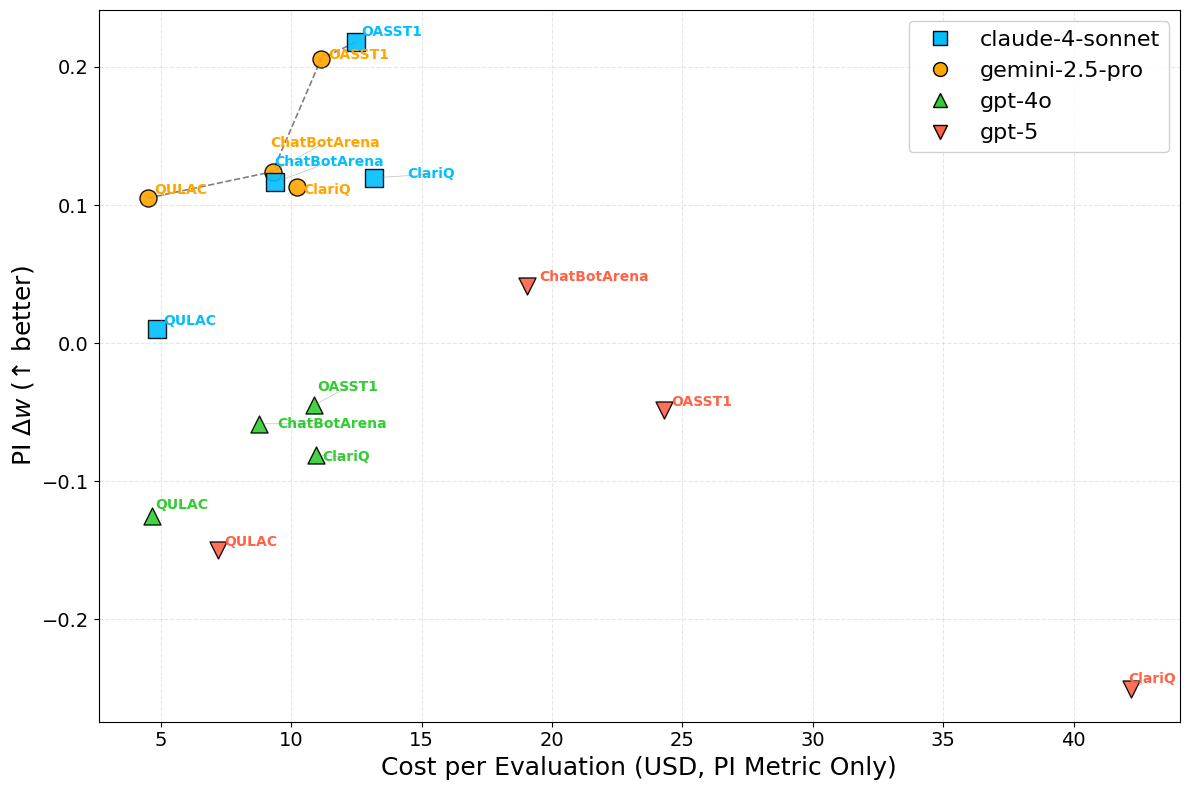


Plotted 16 data points


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Try to import adjustText for smart label positioning
try:
    from adjustText import adjust_text
    HAS_ADJUST_TEXT = True
except ImportError:
    HAS_ADJUST_TEXT = False
    print("Note: Install 'adjustText' for better label positioning: pip install adjustText")

# Prepare data for plotting
model_colors = {
    'gemini-2.5-pro': '#FFA500',      # Orange
    'claude-4-sonnet': '#00BFFF',     # Blue
    'gpt-4o': '#32CD32',              # Green
    'gpt-oss-120b': '#FFD700',        # Yellow/Gold
    'gpt-5': '#FF6347',               # Red-ish (for GPT-5 if needed)
}

model_markers = {
    'gemini-2.5-pro': 'o',
    'claude-4-sonnet': 's',
    'gpt-4o': '^',
    # 'gpt-oss-120b': 'D',
    'gpt-5': 'v',
}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Store annotations for adjustText
texts = []

# Plot each point
for idx, entry in enumerate(pareto_data):
    model = entry['user_model']
    dataset = entry['dataset']
    x = entry['cost_per_evaluation']
    y = entry['pi_deviation']
    
    color = model_colors.get(model, '#808080')
    marker = model_markers.get(model, 'o')
    
    ax.scatter(x, y, c=color, marker=marker, s=150, alpha=0.9, edgecolors='black', linewidth=1)
    
    # Add dataset label next to point with matching color
    # Use varying offsets if adjustText is not available
    if not HAS_ADJUST_TEXT:
        # Simple offset variation to reduce overlaps
        offset_variations = [(5, 5), (5, -15), (-15, 5), (-15, -15), (10, 0), (-20, 0)]
        offset = offset_variations[idx % len(offset_variations)]
        text = ax.annotate(dataset, (x, y), xytext=offset, textcoords='offset points', 
                          fontsize=10, color=color, fontweight='bold')
    else:
        # Use adjustText for smart positioning
        text = ax.text(x, y, dataset, fontsize=10, color=color, fontweight='bold')
        texts.append(text)

# Apply adjustText if available
if HAS_ADJUST_TEXT and texts:
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5),
                expand_points=(1.5, 1.5),
                force_text=(0.5, 0.5),
                force_points=(0.2, 0.2))

# Pareto frontier calculation
def pareto_frontier(cost, quality, eps=1e-12):
    """
    cost: 1D array-like (lower is better)
    quality: 1D array-like (higher is better)
    Returns (front_cost, front_quality, front_indices) sorted by cost asc.
    """
    cost  = np.asarray(cost, dtype=float)
    qual  = np.asarray(quality, dtype=float)

    # sort by cost asc; for equal cost keep the highest quality first
    order = np.lexsort((-qual, cost))
    c_sorted = cost[order]
    q_sorted = qual[order]

    frontier_idx = []
    best_q = -np.inf
    for k, (c, q) in enumerate(zip(c_sorted, q_sorted)):
        if q > best_q + eps:              # strictly better quality than any cheaper point
            frontier_idx.append(order[k]) # keep original index
            best_q = q

    frontier_idx = np.array(frontier_idx)  # Convert to numpy array BEFORE using it
    return cost[frontier_idx], qual[frontier_idx], frontier_idx

# Extract costs and quality values
costs = [entry['cost_per_evaluation'] for entry in pareto_data]
pis = [entry['pi_deviation'] for entry in pareto_data]

# Compute global pareto frontier
fc, fq, _ = pareto_frontier(costs, pis)
# draw as dashed guide
ax.plot(fc, fq, '--', linewidth=1.2, color='gray', zorder=0)

# Formatting
ax.set_xlabel('Cost per Evaluation (USD, PI Metric Only)', fontsize=18)
ax.set_ylabel('PI $\Delta w$ (↑ better)', fontsize=18)
# ax.set_title('Cost vs Quality (PI) Pareto', fontsize=16, fontweight='bold')
# ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

# Change tick label font size
ax.tick_params(axis='both', which='major', labelsize=14)

# Add legend for models
legend_elements = [
    plt.Line2D([0], [0], marker=model_markers.get(model, 'o'), color='w', 
               markerfacecolor=model_colors.get(model, '#808080'), 
               markersize=10, label=model, markeredgecolor='black', markeredgewidth=1)
    for model in sorted(set(entry['user_model'] for entry in pareto_data))
]
ax.legend(handles=legend_elements, loc='best', fontsize=16, framealpha=0.9)

plt.tight_layout()
plt.savefig('.cached/cost_pi_pareto.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"\nPlotted {len(pareto_data)} data points")

In [21]:
# Create a summary table
import pandas as pd

summary_df = pd.DataFrame(pareto_data)
summary_df = summary_df[['dataset', 'user_model', 'pi_deviation', 'cost_per_evaluation']]
summary_df = summary_df.sort_values(['user_model', 'dataset'])

print("Summary Table:")
print("=" * 100)
print(summary_df.to_string(index=False))

print("\n\nGrouped by Model:")
print("=" * 100)
for model in sorted(summary_df['user_model'].unique()):
    model_data = summary_df[summary_df['user_model'] == model]
    avg_perf = model_data['pi_deviation'].mean()
    avg_cost = model_data['cost_per_evaluation'].mean()
    print(f"\n{model}:")
    print(f"  Average PI-deviation: {avg_perf:.4f}")
    print(f"  Average cost per 100: ${avg_cost:.2f}")
    print(f"  Datasets: {', '.join(model_data['dataset'].tolist())}")

Summary Table:
     dataset      user_model  pi_deviation  cost_per_evaluation
ChatBotArena claude-4-sonnet      0.116415             9.372941
      ClariQ claude-4-sonnet      0.119765            13.184733
      OASST1 claude-4-sonnet      0.217755            12.472417
       QULAC claude-4-sonnet      0.010000             4.856316
ChatBotArena  gemini-2.5-pro      0.124167             9.293712
      ClariQ  gemini-2.5-pro      0.113065            10.229531
      OASST1  gemini-2.5-pro      0.206030            11.160196
       QULAC  gemini-2.5-pro      0.105000             4.505920
ChatBotArena          gpt-4o     -0.058333             8.785160
      ClariQ          gpt-4o     -0.080833            10.938851
      OASST1          gpt-4o     -0.045000            10.872688
       QULAC          gpt-4o     -0.125000             4.676347
ChatBotArena           gpt-5      0.041039            19.044889
      ClariQ           gpt-5     -0.250583            42.184837
      OASST1           gp

In [22]:
# Optional: Save the plot to a file
# Uncomment to save
# fig.savefig('cost_quality_pareto.png', dpi=300, bbox_inches='tight')
# print("Plot saved to cost_quality_pareto.png")

# Optional: Save the data to CSV
# summary_df.to_csv('pareto_data.csv', index=False)
# print("Data saved to pareto_data.csv")